In [1]:
#double tbSim(n, channel) ;
#double tbObs(n, channel) ;
#int64 pType(n) ;
#float sfcEmiss(n, channel) ;
#float skTemp(n) ;
#skTemp:_FillValue = NaNf ;
#double wvp(n) ;
#double iwp(n) ;
#double rwp(n) ;

import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

with nc.Dataset("/Volumes/T7 Shield/SUBSETS/output/training_dataset_land_2d_0to120step2.nc") as f:
    tbSim = f.variables["tbConv"][:,1:-1,:,:]
    tbObs = f.variables["tbObs"][:,1:-1,:,:]
    pType = f.variables["pType"][:]
    sfcEmiss = f.variables["sfcEmiss"][:]
    skTemp = f.variables["skTemp"][:,1:-1,:]
    wvp = f.variables["wvp"][:]
    iwp = f.variables["iwp"][:]
    rwp = f.variables["rwp"][:]
    sfcBin= f.variables["sfcBin"][:,1:-1,:]
    zeroDeg= f.variables["zeroDeg"][:,1:-1,:]
    stormTop= f.variables["stormTop"][:]
    oe_wvp= f.variables["oe_wvp"][:]
    sfcPrecip= f.variables["sfcPrecip"][:]


In [9]:
#print(tbSim.mean(axis=0))
print(stormTop.data)
a=np.nonzero(stormTop.data!=stormTop.data)
stormTop[a]=0
print(len(a[0]))
print(oe_wvp.data.mean(),oe_wvp.data.std(),oe_wvp.shape)
a=np.nonzero(zeroDeg.data!=zeroDeg.data)
zeroDeg[a]=0
print(len(a[0]))

[0. 0. 0. ... 0. 0. 0.]
0
23.866926 15.461204 (1874740, 9, 7)
0


6.388173580169678
77.44548797607422


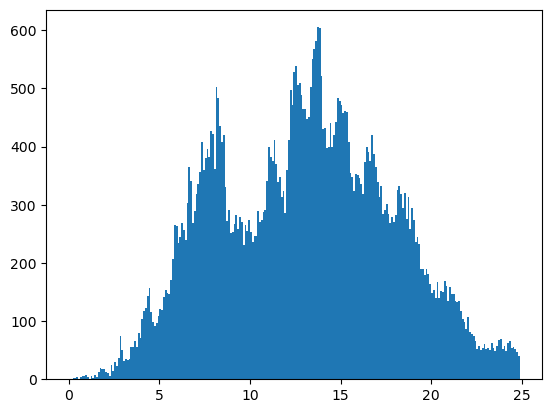

In [11]:
print(rwp.max())
print(iwp.max())
a=np.where(rwp>0)
#h1=plt.hist(rwp[a], bins=50)
b=np.where(iwp>0)
#h2=plt.hist(wvp[b]*1e3, bins=np.arange(0, 25, 0.1))

In [4]:
#normalize tbObs using scaler from sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(tbObs.shape)
scaler.fit(tbObs[:,3,3,:])


(1874740, 7, 7, 9)


StandardScaler()

In [5]:
import pickle
try:
    #del tbObs
    del tbSim
    with open("tbobs_0_60.scaler_2.pkl", "wb") as f:
        pickle.dump(scaler, f)
except:
    print("tbObs already deleted")
tbSim_scaled = tbObs[:,:,:,:9].copy()
#tbSim_scaled = tbSim[:,:,:,:9].copy()
for i in range(9):
    tbSim_scaled[:,:,:,i] = (tbSim_scaled[:,:,:,i] - scaler.mean_[i])/scaler.scale_[i]
    


In [11]:
print(tbSim_scaled.shape)
print(skTemp.shape)
#print(sfcBin_scaled.shape)
print(sfcPrecip.data.mean())
a=np.where(sfcBin.data!=sfcBin.data)
print(zeroDeg.data.mean(), zeroDeg.max())

(1874740, 7, 7, 9)
(1874740, 7, 7)
0.10327203
3672.642 6174.37


In [12]:

gVars=np.concatenate((np.log(1+wvp*1e3/10)[:,np.newaxis], np.log(1+iwp/10)[:,np.newaxis], np.log(1+rwp/10)[:,np.newaxis],stormTop[:,np.newaxis]/10e3,np.log10(1+sfcPrecip[:,np.newaxis]/0.1)), axis=1)


#with nc.Dataset("training_dataset_land_2d.nc") as f:
#    sfcBin=f.variables["sfcBin"][:]
try:
    sfcBin_scaled=(88-sfcBin)/30
    del sfcBin
except:
    print("sfcBin already deleted")

x_forward=np.concatenate((tbSim_scaled, (skTemp-273.15)[:,:,:,np.newaxis]/5,(zeroDeg)[:,:,:,np.newaxis]/2e3,sfcBin_scaled[:,:,:,np.newaxis],((oe_wvp-22)/15.)[:,1:-1,:,np.newaxis]), axis=3)
#print(sfcBin.max(), sfcBin.min(), sfcBin.shape)

In [13]:
# define convolutional neural network to predict gvars from x_forward

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def cnn_model(nout):
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (1, 3), activation='relu', input_shape=(7, 7, 13)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(nout))
    return model

def cnn_model_logit(nout):
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(7, 7, 10)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(nout, activation='sigmoid'))
    return model

forward_model_logit=cnn_model_logit(1)
print(forward_model_logit.summary())

 

#print(forward_modeli.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 5, 32)          2912      
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 2, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [14]:
forward_model_reg=cnn_model(gVars.shape[1])

In [11]:
from sklearn.model_selection import train_test_split
x_mean=x_forward.mean(axis=(1,2,3))
print(x_forward.shape)  
print(gVars.shape)
print(pType.shape)

(2485962, 7, 7, 12)
(2485962, 4)
(2485962,)


In [12]:
print(x_mean.shape)
a=np.where(np.isnan(x_mean))
print(len(a[0]))
a=np.nonzero(x_mean==x_mean)
print(len(a[0]))
#x_forward=x_forward[a]
gVars=gVars[a]
pType=pType[a]
x_forward=x_forward[a]

(2485962,)
1798
2484164


In [15]:

#X_train, X_test, y_train, y_test = train_test_split(x_forward, gVars, test_size=0.2, random_state=42)
# split the data into training and testing, with first 80% as training and last 20% as testing
X_train=x_forward[:int(0.8*x_forward.shape[0]),:,:,:]
X_test=x_forward[int(0.8*x_forward.shape[0]):,:,:,:]
print(X_train.shape)
print(X_test.shape)
y_train=gVars[:int(0.8*gVars.shape[0])]
y_test=gVars[int(0.8*gVars.shape[0]):]
y_rain=pType.copy()
y_rain[y_rain>0]=1
y_rain_train=y_rain[:int(0.8*gVars.shape[0])]
y_rain_test=y_rain[int(0.8*gVars.shape[0]):]
#a=np.where(y_rain>0)
#print(a[0].shape[0]/y_rain.shape[0])


(1499792, 7, 7, 13)
(374948, 7, 7, 13)


In [66]:
print(pType.max())
pType_train=pType[:int(0.8*gVars.shape[0])]

3


In [56]:
print(X_train.mean(), X_test.mean())

-0.011999398714818229 0.013121869189029987


In [16]:
forward_model_reg.compile(optimizer='adam', loss='mean_squared_error')
history = forward_model_reg.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
#history = forward_modeli.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
#weights = np.zeros(y_rain_train.shape[0])+1
#a=np.nonzero(pType_train==2)
#print(len(a[0]))


Epoch 1/10
46869/46869 [==============================] - 71s 2ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 2/10
46869/46869 [==============================] - 73s 2ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 3/10
46869/46869 [==============================] - 76s 2ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 4/10
46869/46869 [==============================] - 78s 2ms/step - loss: 0.0075 - val_loss: 0.0085
Epoch 5/10
46869/46869 [==============================] - 81s 2ms/step - loss: 0.0074 - val_loss: 0.0087
Epoch 6/10
46869/46869 [==============================] - 81s 2ms/step - loss: 0.0073 - val_loss: 0.0084
Epoch 7/10
46869/46869 [==============================] - 83s 2ms/step - loss: 0.0072 - val_loss: 0.0088
Epoch 8/10
46869/46869 [==============================] - 86s 2ms/step - loss: 0.0071 - val_loss: 0.0085
Epoch 9/10
46869/46869 [==============================] - 83s 2ms/step - loss: 0.0071 - val_loss: 0.0084
Epoch 10/10
46869/46869 [==============================

In [68]:

weights[a]=3
forward_model_logit.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = forward_model_logit.fit(X_train, y_rain_train, sample_weight=weights, epochs=5, batch_size=32, validation_data=(X_test, y_rain_test))

Epoch 1/5
64787/64787 [==============================] - 130s 2ms/step - loss: 0.0976 - accuracy: 0.9704 - val_loss: 0.1122 - val_accuracy: 0.9580
Epoch 2/5
64787/64787 [==============================] - 150s 2ms/step - loss: 0.0965 - accuracy: 0.9705 - val_loss: 0.1168 - val_accuracy: 0.9568
Epoch 3/5
64787/64787 [==============================] - 132s 2ms/step - loss: 0.0954 - accuracy: 0.9708 - val_loss: 0.1170 - val_accuracy: 0.9570
Epoch 4/5
64787/64787 [==============================] - 132s 2ms/step - loss: 0.0949 - accuracy: 0.9710 - val_loss: 0.1203 - val_accuracy: 0.9584
Epoch 5/5
64787/64787 [==============================] - 133s 2ms/step - loss: 0.0955 - accuracy: 0.9709 - val_loss: 0.1150 - val_accuracy: 0.9593


In [18]:
#history = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
#y_pred=forward_modeli.predict(X_test)
y_pred=forward_model_reg.predict(X_test)
#a=np.where(y_rain_test>0)
#print(y_pred[a].mean())
#print(len(a[0])/y_rain_test.shape[0])
#print(y_pred.mean())
for i in range(0,5):
    print(i,np.corrcoef(y_pred[:,i], y_test[:,i])[0,1])


11718/11718 [==============================] - 6s 537us/step
0 0.9695787743414197
1 0.6869701228581135
2 0.48423510045484724
3 0.8742781675765466
4 0.8295271169766169


In [20]:
forward_model_reg.save("forward_model_regr_obsTb_0_120.h5")
#forward_modeli.save("forward_model_convTb_60_120.h5")

In [16]:
y_pred=forward_model.predict(X_test)
for i in range(0,13):
    print(i,np.corrcoef(y_pred[:,i], y_test[:,i])[0,1])

16220/16220 [==============================] - 9s 567us/step
0 0.9544457480132158
1 0.9701451943942454
2 0.952660119363961
3 0.9698053163888835
4 0.9440678276683427
5 0.9395266805501635
6 0.9669406808146099
7 0.8889461150602018
8 0.9551732473943823
9 0.8390881438061667
10 0.9180953430703173
11 0.8390881519277223
12 0.8390881286894252


In [69]:
#forward_modeli.save("forward_model_60to120_noover_10iters.h5")
forward_model_logit.save("forward_model_gmi_60to120_rain_4iters.h5")

/Users/mgrecu/miniconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
